In [1]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# 予測結果の精度確認（ROC曲線の描画）
from sklearn.metrics import roc_auc_score, roc_curve
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt

In [2]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset

## 訓練データの読み込み

In [3]:
# CSVファイル読み込み（訓練データ）
df_train = pd.read_csv('train.csv')
df_train.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [4]:
# 性別を変換する（訓練データ）
# gemder=pd.get_dummies(df_train.loc[:,['Gender']])
# df_train['Female']=gemder.loc[:,['Gender_Female']]
# df_train['Male']=gemder.loc[:,['Gender_Male']]
df_train.drop(columns=['Gender'],inplace=True)
df_train.drop(columns=['Age'],inplace=True)
df_train.head()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [5]:
df_train.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,1.607337,0.606737,272.211316,41.978476,61.018120,7.032290,3.517458,1.144570,0.444706
std,2.443585,1.569032,200.348515,145.927366,110.125390,0.840664,0.559942,0.227237,0.497226
min,0.585961,0.034861,163.261838,3.924518,11.283497,4.858679,2.180884,0.627133,0.000000
25%,0.781258,0.144889,213.991414,13.644658,21.239157,6.730612,3.139153,1.004466,0.000000
50%,0.835591,0.194085,220.092503,16.638001,27.056026,6.915580,3.621339,1.205016,0.000000
75%,1.196759,0.335447,229.455927,23.056081,56.461568,7.536151,3.712524,1.287880,1.000000
max,23.017027,17.692164,2108.483728,1423.186473,814.439397,8.739000,5.016970,1.821496,1.000000


# 評価データの読み込み

In [6]:
# CSVファイル読み込み（評価データ）
df_vat = pd.read_csv('test.csv')
df_vat.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,65,Male,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,34,Female,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


In [7]:
# 性別を変換する（検証データ）
# gemder=pd.get_dummies(df_vat.loc[:,['Gender']])
# df_vat['Female']=gemder.loc[:,['Gender_Female']]
# df_vat['Male']=gemder.loc[:,['Gender_Male']]
df_vat.drop(columns=['Gender'],inplace=True)
df_vat.drop(columns=['Age'],inplace=True)
df_vat.head()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


## データを加工する

In [8]:
def xConv(x_tmp):
    # T_Bilの変換
    bins = [0, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 100]
    x_tmp=comCutCnnect2(x_tmp, bins, 'T_Bil')

    # D_Bilの変換
    bins = [0, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 100]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'D_Bil' )
    
    # ALPの変換
    bins = [0, 200, 210, 220, 225, 230, 300, 350, 600 , 2500]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'ALP' )
    
    # ALT_GPTの変換
    bins = [0,  10, 12.5, 15, 17.5, 20, 22.5, 25, 50, 100, 1500]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'ALT_GPT' )
    
    # AST_GOTの変換
    bins = [0, 20, 25, 30, 40, 50, 60, 1000]
    x_tmp=comCutCnnect2(x_tmp, bins, 'AST_GOT' )

    # TPの変換
    bins = [0, 5.5, 6, 6.5, 7, 75, 1000]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'TP' )
    
    # Albの変換
    bins = [0, 2.5, 2.8, 3.3, 3.8, 4.5, 1000]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'Alb' )

    # AG_ratioの変換
    bins = [0, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1000]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'AG_ratio' )
    
    # Ageの変換の変換
#    bins = [0, 18, 25, 30, 35, 40, 50, 60, 70, 80 ,1000]
#    x_tmp=comCutCnnect(x_tmp,  bins, 'Age' )
        
    return x_tmp


def comCutCnnect(x_tmp, bins ,col ):   
    X_cut = pd.cut(x_tmp[col], bins=bins, labels=False)
    cutTemp = np.zeros((len(X_cut), len(bins) -1 ), dtype=int)
    cutTemp[np.arange(len(X_cut)), X_cut.T] = 1
    
    df=pd.DataFrame(cutTemp ,columns=[col + str(x) for x in range(cutTemp.shape[1])])
    
    # 列の削除
    x_tmp.drop(columns=[col], inplace=True, axis=1)
    # 列の追加
    x_tmp = pd.concat([x_tmp, df], axis=1)

    return x_tmp 

def comCutCnnect2(x_tmp, bins ,col ):   
    X_cut = pd.cut(x_tmp[col], bins=bins, labels=False)
    
    # 列の削除
    x_tmp.drop(columns=[col], inplace=True, axis=1)
    # 列の追加
    x_tmp = pd.concat([x_tmp, X_cut], axis=1)

    return x_tmp 

In [9]:
# 特徴量選択
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# 多項式・交互作用特徴量
from sklearn.preprocessing import PolynomialFeatures


#### 訓練データのデータ加工前処理

In [10]:
# 説明変数（訓練データ）
#x_tmp=xConv(df_train.loc[:,['Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio', 'Female', 'Male']])
x_tmp=xConv(df_train.loc[:,['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio']])

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


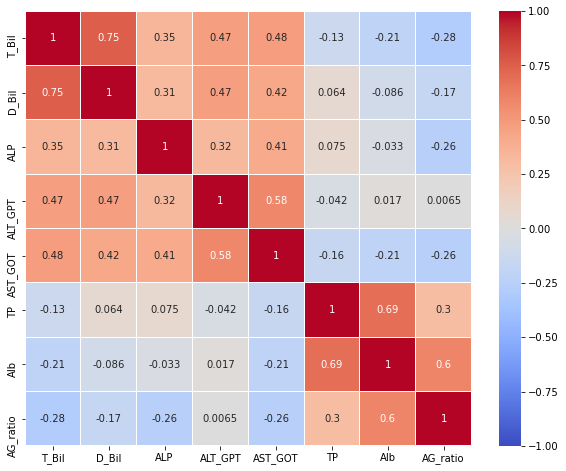

In [11]:
# seabornライブラリをsnsという省略名でインポート
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(x_tmp.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

In [12]:
print(x_tmp.head())

   T_Bil  D_Bil  ALP  ALT_GPT  AST_GOT  TP  Alb  AG_ratio
0      0      2    3        2        1   3    2         3
1      3      2    3        8        6   3    2         0
2      0      0    6        2        3   1    0         0
3      2      3    7        7        5   3    3         2
4      6      2    3        5        6   1    2         3


In [13]:
print(x_tmp.shape)

(850, 8)


In [14]:
# 目的変数（訓練データ）
y_train = np.array(df_train.loc[:,['disease']])

# 組み込み法に使うモデルの指定
fs_model = LogisticRegression(penalty='l2', random_state=0)
# 閾値の指定
fs_threshold = "mean"
# 組み込み法モデルの初期化
selector = SelectFromModel(fs_model, threshold=fs_threshold)

# 特徴量生成
polynomial = PolynomialFeatures(degree=3, include_bias=False)
polynomial_arr = polynomial.fit_transform(np.array(x_tmp))
# polynomial_arrのデータフレーム化 （※カラムはshape[1]でpolynomial_arrの列数分だけ出力）
X_polynomial = pd.DataFrame(polynomial_arr, columns=["poly" + str(x_) for x_ in range(polynomial_arr.shape[1])])

# 特徴量選択の実行
selector.fit(X_polynomial, y_train)
mask = selector.get_support()

# 選択された特徴量だけのサンプル取得
X_polynomial_masked = X_polynomial.loc[:, mask]

x_train = np.array(X_polynomial_masked)




C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [15]:
X_polynomial.describe()

,poly0,poly1,poly2,poly3,poly4,poly5,poly6,poly7,poly8,poly9,...,poly154,poly155,poly156,poly157,poly158,poly159,poly160,poly161,poly162,poly163
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,...,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,2.124706,2.738824,3.284706,3.823529,2.770588,3.023529,2.698824,3.792941,11.030588,9.296471,...,37.520000,32.096471,42.722353,29.275294,39.015294,58.357647,28.230588,37.795294,56.378824,91.449412
std,2.554190,1.808897,2.124816,2.430065,2.216297,1.126577,1.053850,1.869587,18.008544,14.166405,...,24.453513,22.463479,32.284193,23.342929,32.033860,50.325926,26.259841,35.133942,53.004678,89.035470
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,3.000000,0.000000,0.000000,...,27.000000,18.000000,12.000000,12.000000,12.000000,12.000000,8.000000,12.000000,12.000000,27.000000
50%,1.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,5.000000,1.000000,2.000000,...,27.000000,27.000000,45.000000,27.000000,36.000000,36.000000,27.000000,27.000000,48.000000,125.000000
75%,3.750000,4.000000,4.000000,6.000000,5.000000,4.000000,3.000000,5.000000,14.250000,12.000000,...,64.000000,48.000000,80.000000,36.000000,60.000000,100.000000,27.000000,48.000000,75.000000,125.000000
max,7.000000,6.000000,8.000000,9.000000,6.000000,4.000000,5.000000,7.000000,49.000000,42.000000,...,64.000000,80.000000,112.000000,100.000000,140.000000,196.000000,125.000000,175.000000,245.000000,343.000000


In [16]:
X_polynomial_masked.describe()

,poly2,poly4,poly7,poly8,poly9,poly23,poly24,poly31,poly34,poly37,...,poly145,poly148,poly149,poly151,poly152,poly153,poly154,poly156,poly159,poly162
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,...,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,3.284706,2.770588,3.792941,11.030588,9.296471,15.298824,14.217647,11.447059,12.582353,9.442353,...,35.892941,26.535294,22.345882,20.818824,27.390588,43.423529,37.520000,42.722353,58.357647,56.378824
std,2.124816,2.216297,1.869587,18.008544,14.166405,18.186253,14.718110,8.662098,14.232411,9.776277,...,44.814777,27.436605,23.556921,23.405981,32.647316,55.041365,24.453513,32.284193,50.325926,53.004678
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,3.000000,0.000000,0.000000,4.000000,4.000000,4.000000,1.000000,2.000000,...,3.000000,4.250000,4.000000,4.000000,0.000000,4.000000,27.000000,12.000000,12.000000,12.000000
50%,3.000000,2.000000,5.000000,1.000000,2.000000,9.000000,8.000000,9.000000,4.000000,6.000000,...,9.000000,16.000000,12.000000,16.000000,15.000000,25.000000,27.000000,45.000000,36.000000,48.000000
75%,4.000000,5.000000,5.000000,14.250000,12.000000,16.000000,21.000000,16.000000,25.000000,14.000000,...,72.000000,45.000000,36.000000,25.000000,36.000000,50.000000,64.000000,80.000000,100.000000,75.000000
max,8.000000,6.000000,7.000000,49.000000,42.000000,64.000000,72.000000,36.000000,36.000000,42.000000,...,144.000000,96.000000,120.000000,150.000000,210.000000,294.000000,64.000000,112.000000,196.000000,245.000000


In [17]:
X_polynomial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Columns: 164 entries, poly0 to poly163
dtypes: float64(164)
memory usage: 1.1 MB


In [18]:
X_polynomial_masked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 69 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   poly2    850 non-null    float64
 1   poly4    850 non-null    float64
 2   poly7    850 non-null    float64
 3   poly8    850 non-null    float64
 4   poly9    850 non-null    float64
 5   poly23   850 non-null    float64
 6   poly24   850 non-null    float64
 7   poly31   850 non-null    float64
 8   poly34   850 non-null    float64
 9   poly37   850 non-null    float64
 10  poly42   850 non-null    float64
 11  poly43   850 non-null    float64
 12  poly44   850 non-null    float64
 13  poly45   850 non-null    float64
 14  poly48   850 non-null    float64
 15  poly50   850 non-null    float64
 16  poly51   850 non-null    float64
 17  poly52   850 non-null    float64
 18  poly55   850 non-null    float64
 19  poly56   850 non-null    float64
 20  poly57   850 non-null    float64
 21  poly58   850 non

#### 評価データのデータ加工前処理

In [19]:
# 説明変数（評価データ）
x_tmp=xConv(df_vat)

In [20]:

# 組み込み法に使うモデルの指定
fs_model = LogisticRegression(penalty='l2', random_state=0)
# 閾値の指定
fs_threshold = "mean"
# 組み込み法モデルの初期化
selector = SelectFromModel(fs_model, threshold=fs_threshold)

# 特徴量生成
polynomial = PolynomialFeatures(degree=3, include_bias=False)
polynomial_arr = polynomial.fit_transform(x_tmp)
# polynomial_arrのデータフレーム化 （※カラムはshape[1]でpolynomial_arrの列数分だけ出力）
X_polynomial = pd.DataFrame(polynomial_arr, columns=["poly" + str(x) for x in range(polynomial_arr.shape[1])])

# 選択された特徴量だけのサンプル取得
X_polynomial_masked = X_polynomial.loc[:, mask]

x_vat = np.array(X_polynomial_masked)


In [21]:
y = np.zeros((len(y_train), 1 + y_train.max()), dtype=int)
y[np.arange(len(y_train)), y_train.T] = 1
y_train = y
X_train,X_test,Y_train,Y_test=train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

In [22]:
# 標準化
#from sklearn.preprocessing import StandardScaler,MinMaxScaler
#sc = StandardScaler() 
#norm = MinMaxScaler()
#X_train=sc.fit_transform(X_train)
#X_test=sc.transform(X_test)
#X_vat=sc.transform(x_vat)

In [23]:
# numpy の値を torch の値に変換する
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()
X_vat  = torch.from_numpy(x_vat).float()

In [24]:
# 行数、列数の確認
in_size=X_train.shape[1]
print(X_train.shape)
print(X_test.shape)


torch.Size([637, 69])
torch.Size([213, 69])


In [25]:
out_size=Y_train.shape[1]
Y_train.shape

torch.Size([637, 2])

In [26]:
print(X_vat.shape)


torch.Size([350, 69])


In [27]:
# x と y の値をひとつの変数に格納する
train = TensorDataset(X_train ,Y_train)

In [28]:
# batch_size ：学習する時にまとめるデータ数
# shuffle    : データをランダムに並び替える場合はTrue
#train_loader = DataLoader(train ,batch_size=30, shuffle=True, num_workers=2)
train_loader = DataLoader(train ,batch_size=30, shuffle=True)

In [29]:
node1=150
node2=100
node3=60
node4=20


# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net ,self).__init__()
        #   中間層のノード数は、精度向上やパフォーマンス向上を狙って調整する
        self.fc1 = nn.Linear(in_size , node1)         # nn.Linear (入力のノード数 , 中間層ノード数)
        self.fc2 = nn.Linear(node1 , node2)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc3 = nn.Linear(node2 , node3)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc4 = nn.Linear(node3 , node4)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc5 = nn.Linear(node4,  out_size)        # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
#        x = torch.relu(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
#        x = F.sigmoid(self.fc2(x))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        y = torch.sigmoid (self.fc1(x))               # 入力のノードを中間層（１階層目）に渡して結果を得る
        y = torch.sigmoid(self.fc2(y))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        y = torch.sigmoid(self.fc3(y))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        y = torch.sigmoid(self.fc4(y))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        y = torch.sigmoid(self.fc5(y))            # 中間層（２階層目）の結果を出力層に渡す
        # dim　:求めたい確率の値　今回は１になる確率
        #return F.log_softmax(y , dim=0)
        return y

In [30]:
# モデルの定義
model = Net()
# 損失の定義 (平均二乗誤差)
#criterion = nn.MSELoss()
# 損失の定義 (平均二乗誤差)
criterion = nn.BCELoss()
# 損失の定義 (交差エントロピー誤差関数)
#criterion = nn.CrossEntropyLoss()

In [31]:
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
## model.parameters  調整する値
## lr(learning rate) ：学習率　どれぐらいの幅でパラメータを更新していくのか
optimizer = optim.Adam(model.parameters() , lr=0.005)
#optimizer = optim.SGD(model.parameters() , lr=0.001)

In [32]:
loss_list = []
loss_temp = 0
logdisp=10
# トレーニングの回数分ループする。
for epoch in range(200):
    # 損失を初期化　
    total_loss = 0
    
    # データの件数分ループする。（x_train , y_train　に１レコードずつ格納される）
    for x_train , y_train in train_loader:
        # Variable ：　torch,autograd.Variable  ：テンソルをwrapして計算操作を記録する
        x_train ,y_train = Variable(x_train) ,Variable(y_train)
        # 出力を計算する 
        output = model(x_train)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss = criterion(output ,y_train)
        # パラメータの勾配を初期化する
        optimizer.zero_grad()
        # ロスを伝播する
        loss.backward()
        # パラメータを更新する
        optimizer.step()
        # トータルロスを格納
        total_loss += loss.item()
        loss_temp += loss

    # 10回毎に回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_list.append(loss.item()/(logdisp*len(train_loader)))
        print(f'Epoch {epoch+1} Loss {loss.item()/(logdisp*len(train_loader))} -- {loss_temp}')
        loss_temp = 0

Epoch 10 Loss 0.001810920238494873 -- 98.74346160888672
Epoch 20 Loss 0.0004319452087987553 -- 81.4933853149414
Epoch 30 Loss 0.0007131460715423931 -- 76.83442687988281
Epoch 40 Loss 0.0005372370847246863 -- 72.99356079101562
Epoch 50 Loss 0.002281338789246299 -- 71.78170013427734
Epoch 60 Loss 0.0019156198609958995 -- 73.78997802734375
Epoch 70 Loss 0.0025886858051473445 -- 72.70684051513672
Epoch 80 Loss 0.004417908462611112 -- 66.6470947265625
Epoch 90 Loss 0.0020123709331859242 -- 64.63426208496094
Epoch 100 Loss 0.001361630992455916 -- 64.14146423339844
Epoch 110 Loss 0.0025164140896363693 -- 58.76580047607422
Epoch 120 Loss 0.00011621299623088403 -- 60.93084716796875
Epoch 130 Loss 0.00028110568157651205 -- 55.927345275878906
Epoch 140 Loss 0.00038945349779996005 -- 59.11903381347656
Epoch 150 Loss 0.000616494972597469 -- 56.890079498291016
Epoch 160 Loss 0.0005418034101074392 -- 55.85908126831055
Epoch 170 Loss 0.0005804128267548301 -- 53.56873321533203
Epoch 180 Loss 0.00135583

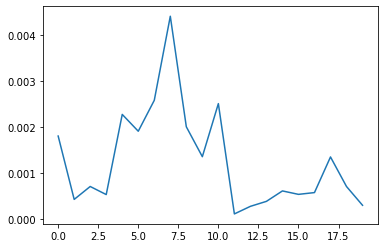

In [33]:
# ロスのプロット
plt.plot(loss_list)

## 誤差の確認

In [34]:
#print(Y_test)

In [35]:
# 学習を行わないモードに変更
model.eval()

# テストデータ
x ,y = Variable(X_test) ,Variable(Y_test)
# テストデータｘに対する結果　（値の大きい方を取得する）
y_hat = torch.max(model(x).data ,1)[1]
y_true = torch.max(y ,1)[1]
# テストｘの結果とｙの比較　（結果が一致したら加算して、不一致は加算しない。その結果をデータ数で割る）
accuracy = np.sum(y_true.data.numpy() == y_hat.numpy()) /len(y_true.data.numpy())
print(accuracy)
print(y_hat.numpy())
print(y_true.data.numpy())

0.8685446009389671
[0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1
 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0
 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0
 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0]
[1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1
 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0
 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1
 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0]


In [36]:
# 学習を行わないモードに変更
model.eval()

# テストデータ
x ,y = Variable(X_test) ,Variable(Y_test)
# テストデータｘに対する結果　（値の大きい方を取得する）
y_hat = torch.max(model(x).data ,1)[1]
y_true = torch.max(y ,1)[1]
# テストｘの結果とｙの比較　（結果が一致したら加算して、不一致は加算しない。その結果をデータ数で割る）
accuracy = np.sum(y_true.data.numpy() == y_hat.numpy()) /len(y_true.data.numpy())
print(accuracy)
print(y_hat.numpy())
print(y_true.data.numpy())

0.8685446009389671
[0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1
 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0
 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0
 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0]
[1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1
 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0
 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1
 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1
 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0]


## ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）

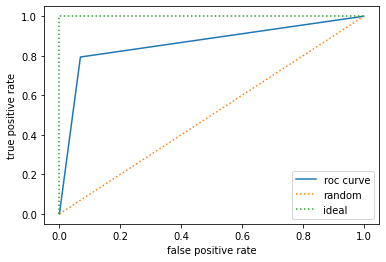

[2 1 0]


In [37]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_hat)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print(thresholds)

In [38]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_true, y_score=y_hat)
print("AUC:", auc_score)

AUC: 0.8624244578741557


#  予測する

In [39]:
y_predict = torch.max(model(X_vat).data ,1)[1]
df_out = pd.DataFrame(np.array(y_predict.detach().numpy().copy(),dtype=np.int64), columns=['val'])
print(df_out)
df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False)


     val
0      0
1      0
2      0
3      0
4      0
..   ...
345    0
346    0
347    0
348    0
349    1

[350 rows x 1 columns]


# モデルの保存

In [40]:
#model_path = 'model.pth'
#torch.save(model.to('cpu').state_dict(), model_path)